<a href="https://colab.research.google.com/github/atharabbas993/Count-object-crossing-Line/blob/main/Count_track_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install -q ultralytics supervision==0.18.0

In [ ]:
import numpy as np
import supervision as sv

from ultralytics import YOLO
from supervision.assets import download_assets, VideoAssets

In [ ]:
SOURCE_VIDEO_PATH = "/content/Highway_road.mp4"

In [ ]:
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(generator)

sv.plot_image(frame, (12, 12))

Exception: Could not open video at /content/Highway_road.mp4

In [ ]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

In [ ]:
model = YOLO("yolov8x.pt")

results = model(frame, verbose=True)[0]
detections = sv.Detections.from_ultralytics(results)

NameError: name 'frame' is not defined

In [ ]:
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=4)
annotated_frame = bounding_box_annotator.annotate(frame.copy(), detections)
sv.plot_image(annotated_frame, (12, 12))

In [ ]:
labels = [
    f"{results.names[class_id]} {confidence:0.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)

annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)
sv.plot_image(annotated_frame, (12, 12))

NameError: name 'detections' is not defined

In [ ]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=29, total_frames=1573)

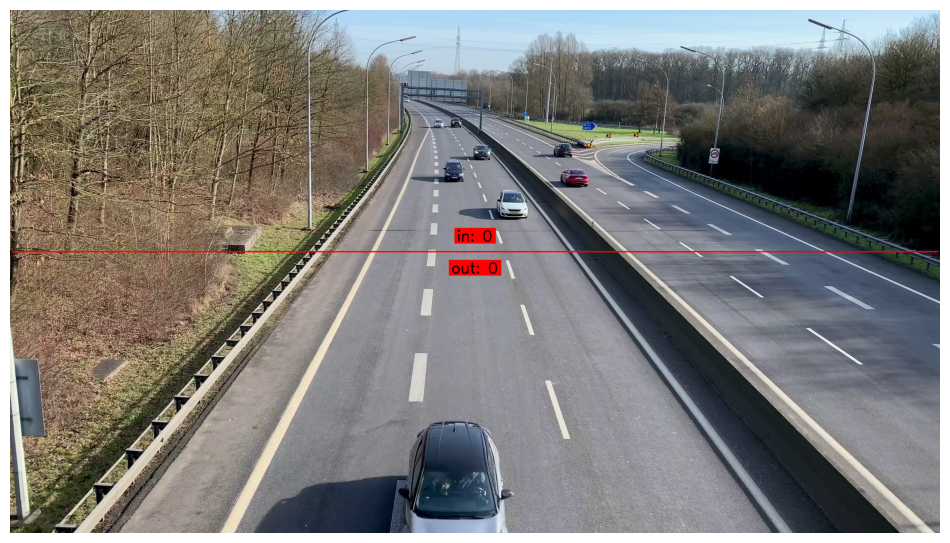

In [ ]:
START = sv.Point(0, 1000)
END = sv.Point(3840, 1000)

line_zone = sv.LineZone(start=START, end=END)

line_zone_annotator = sv.LineZoneAnnotator(
    thickness=4,
    text_thickness=4,
    text_scale=2,
    color=sv.Color.RED)

annotated_frame = frame.copy()
annotated_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)
sv.plot_image(annotated_frame, (12, 12))

In [ ]:
byte_tracker = sv.ByteTrack()

In [ ]:
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)
trace_annotator = sv.TraceAnnotator(thickness=4)

In [ ]:
def callback(frame: np.ndarray, index:int) -> np.ndarray:
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = byte_tracker.update_with_detections(detections)

    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]

    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(
        scene=annotated_frame,
        detections=detections)
    annotated_frame = bounding_box_annotator.annotate(
        scene=annotated_frame,
        detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels)

    line_zone.trigger(detections)

    return  line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

In [ ]:
TARGET_VIDEO_PATH = f"{HOME}/count-objects-crossing-the-line-result.mp4"

In [ ]:
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)